In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hodgkin_huxley import HH
from neurodynex3.tools import input_factory

# 1 Exploration of HH neurons

In [2]:
def plot_data(state_monitor, title=None, model_type = "regular"):
    """Plots the state_monitor variables ["vm", "I_e", "m", "n", "h"] vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """
    plt.rcParams["figure.figsize"] = (min(15,8 * state_monitor.vm[0].shape[0] / 200),8)

    plt.subplot(611)
    plt.plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2)

    plt.xlabel("t [ms]")
    plt.ylabel("v [mV]")
    plt.grid()

    plt.subplot(612)

    plt.plot(state_monitor.t / b2.ms, state_monitor.m[0]**3 / b2.volt, "black", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.n[0]**4 / b2.volt, "blue", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.h[0] / b2.volt, "red", lw=2)
    plt.xlabel("t (ms)")
    plt.ylabel("act./inact.")
    plt.legend(("m^3", "n^4", "h"), loc='upper right')
    plt.ylim((0, 1))
    plt.grid()

    plt.subplot(613)
    plt.plot(state_monitor.t / b2.ms, state_monitor.I_e[0] / b2.uamp, lw=2)
    plt.axis((
        0,
        np.max(state_monitor.t / b2.ms),
        min(state_monitor.I_e[0] / b2.uamp) * 1.1,
        max(state_monitor.I_e[0] / b2.uamp) * 1.1
    ))

    plt.xlabel("t [ms]")
    plt.ylabel("I [micro A]")
    plt.grid()

    plt.subplot(614)

    plt.plot(state_monitor.t / b2.ms, state_monitor.I_Na[0] / b2.uamp, "blue", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.I_K[0] / b2.uamp, "black", lw=2)
    plt.xlabel("t (ms)")
    plt.ylabel("ionic currents")
    plt.legend(("I_Na", "I_K"), loc='upper right')
    plt.grid()

    if model_type == "adaptive":
        plt.subplot(615)
        plt.plot(state_monitor.t / b2.ms, state_monitor.I_M[0] / b2.uamp, "red", lw=2)
        plt.xlabel("t (ms)")
        plt.ylabel("ionic currents")
        plt.legend(("I_M"), loc='upper right')
        plt.grid()

        plt.subplot(616)
        plt.plot(state_monitor.t / b2.ms, state_monitor.p[0] / b2.volt, "black", lw=2)
        plt.xlabel("t (ms)")
        plt.ylabel("p")
        plt.legend(("p"), loc='upper right')
        plt.ylim((0, 1))
        plt.grid()

    if title is not None:
        plt.suptitle(title)

    plt.show()


## 1.1 Getting started

In [3]:
def simulate_HH_neuron_regular(input_current, simulation_time):

    """A regular Hodgkin-Huxley neuron implemented in Brian2. Parameters are set 
    according to their values in the pdf.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h", "I_Na", "I_K"]
    """

    # neuron parameters with their specific values
    El = -70 * b2.mV 
    EK = -90 * b2.mV 
    ENa = 50 * b2.mV 
    gl = 0.1 * b2.msiemens 
    gK = 5 * b2.msiemens 
    gNa = 50 * b2.msiemens 
    C = 1 * b2.ufarad 

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa*m**3*h*(vm-ENa) : amp
    I_K = gK*n**4*(vm-EK) : amp
    I_L = gl*(vm-El)  : amp
    membrane_Im = I_e - I_Na  - I_L - I_K  : amp
    alphah = .128*exp(-(43. + vm/mV)/18.)/ms    : Hz
    alpham = -.32*(47. + vm/mV)/(exp(-0.25*(47.+vm/mV))-1)/ms : Hz
    alphan = -.032*(45. + vm/mV)/(exp(-0.2*(45.+vm/mV))-1)/ms : Hz
    betah = 4./(1+exp(-0.2*(20. + vm/mV)))/ms : Hz
    betam = 0.28*(20. + vm/mV)/(-1+exp(0.2*(20. + vm/mV)))/ms : Hz
    betan = .5*exp(-(50. + vm/mV)/40.)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = -70 * b2.mV
    neuron.m = 0
    neuron.h = 1
    neuron.n = 0

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h", "I_Na", "I_K"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

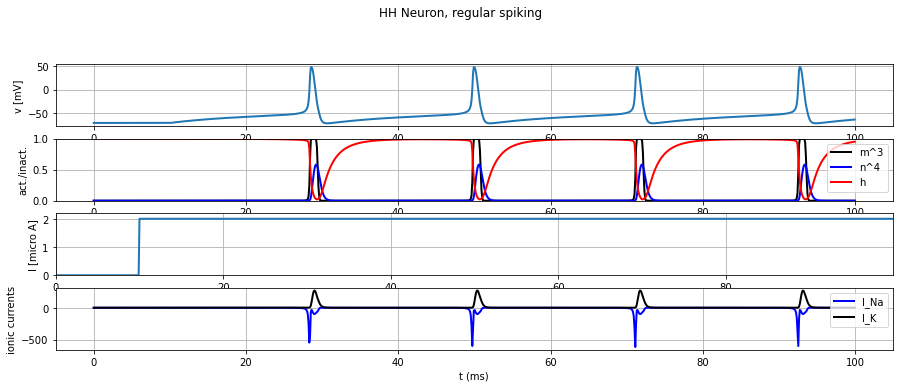

After a simulation of 100 ms, the gating variables reached the values: 
m : 0.007742673590502766, n : 0.02427502611992914, h : 0.9497672996341818, vm : -0.06289215336583717


In [4]:
I_min = 2
sim_time = 100
current = input_factory.get_step_current(10, 100, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron_regular(current, sim_time * b2.ms)
plot_data(state_monitor, title="HH Neuron, regular spiking")

print(f'After a simulation of {sim_time} ms, the gating variables reached the values: ')
print(f'm : {state_monitor.m[0,-1]}, n : {state_monitor.n[0,-1]}, h : {state_monitor.h[0,-1]}, vm : {state_monitor.vm[0,-1]}')

In [5]:
def simulate_HH_neuron_adaptive(input_current, simulation_time):

    """An adaptive Hodgkin-Huxley neuron implemented in Brian2. Parameters are set 
    according to their values in the pdf.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h", "I_Na", "I_K", "I_M", "I_L, "p"]
    """

    # neuron parameters with their specific values
    El = -70 * b2.mV 
    EK = -90 * b2.mV 
    ENa = 50 * b2.mV 
    gl = 0.1 * b2.msiemens 
    gK = 5 * b2.msiemens 
    gNa = 50 * b2.msiemens 
    gm = 0.07 * b2.msiemens
    C = 1 * b2.ufarad 

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa*m**3*h*(vm-ENa) : amp
    I_K = gK*n**4*(vm-EK) : amp
    I_L = gl*(vm-El)  : amp
    I_M = gm*p*(vm-EK): amp
    membrane_Im = I_e - I_Na  - I_L - I_K - I_M : amp
    alphah = .128*exp(-(43 + vm/mV)/18)/ms    : Hz
    alpham = -.32*(47 + vm/mV)/(exp(-0.25*(47+vm/mV))-1)/ms : Hz
    alphan = -.032*(45 + vm/mV)/(exp(-0.2*(45+vm/mV))-1)/ms : Hz
    betah = 4./(1+exp(-0.2*(20 + vm/mV)))/ms : Hz
    betam = 0.28*(20 + vm/mV)/(-1+exp(0.2*(20 + vm/mV)))/ms : Hz
    betan = .5*exp(-(50 + vm/mV)/40)/ms : Hz
    p_inf = 1./(1. + exp(-.1*(40 + vm/mV))) : 1
    t_p = 2000/(3.3*exp((20 + vm/mV)/20) + exp(-(20 + vm/mV)/20))*ms : second
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dp/dt = (p_inf - p)/t_p : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = -70 * b2.mV
    neuron.m = 0
    neuron.h = 1
    neuron.n = 0
    neuron.p = 0

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h", "I_Na", "I_K", "I_M", "I_L", "p"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

WARNING    /tmp/ipykernel_49386/2424631004.py:30: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


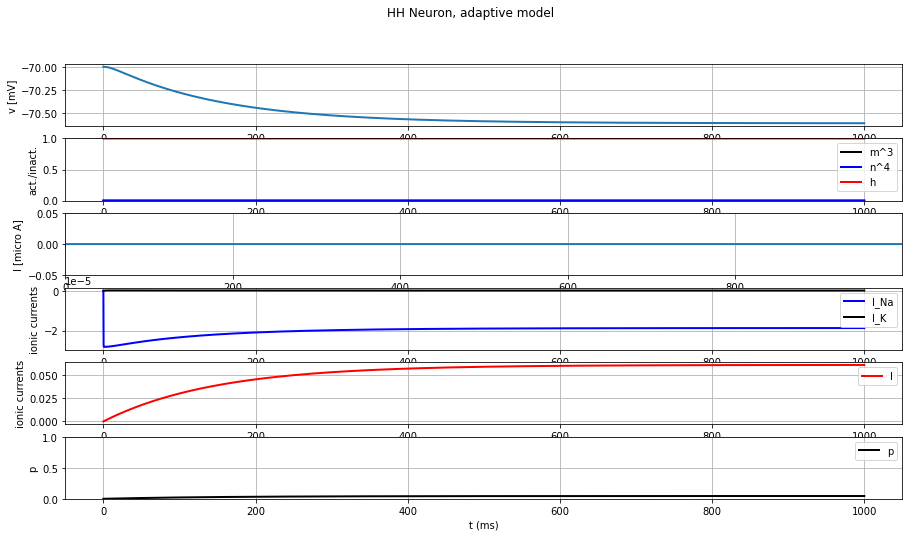

After a simulation of 1000 ms, the gating variables reached the values: 
m : 0.0014598126613983786, n : 0.005843709716632629, h : 0.9997289809867934, p : 0.04470474918655147,  vm : -0.07060664656382752 


In [6]:
I_min = 0
sim_time = 1000
current = input_factory.get_step_current(10, 100, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron_adaptive(current, sim_time * b2.ms)
plot_data(state_monitor, title="HH Neuron, adaptive model", model_type='adaptive')

print(f'After a simulation of {sim_time} ms, the gating variables reached the values: ')
print(f'm : {state_monitor.m[0,-1]}, n : {state_monitor.n[0,-1]}, h : {state_monitor.h[0,-1]}, p : {state_monitor.p[0,-1]},  vm : {state_monitor.vm[0,-1]} ')

## 1.2 Rebound spike?

In [7]:
def plot_gating_variables(state_monitor, title=None, model_type = "regular"):
    """Plots the state_monitor variables ["vm", "I_e", "m", "n", "h"] vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """
    plt.rcParams["figure.figsize"] = (min(15,8 * state_monitor.vm[0].shape[0] / 200),8)
    vm = state_monitor.vm[0] / b2.mV

    alphah = .128*np.exp(-(43 + vm)/18)
    alpham = -.32*(47 + vm)/(np.exp(-0.25*(47+vm))-1)
    alphan = -.032*(45 + vm)/(np.exp(-0.2*(45+vm))-1)
    betah = 4./(1+np.exp(-0.2*(20 + vm)))
    betam = 0.28*(20 + vm)/(-1+np.exp(0.2*(20 + vm)))
    betan = .5*np.exp(-(50 + vm)/40)

    t_m = 1 / (alpham + betam)
    t_n = 1 / (alphan + betan)
    t_h = 1 / (alphah + betah)

    m_inf = alpham * t_m
    n_inf = alphan * t_n
    h_inf = alphah * t_h

    plt.subplot(311)

    plt.plot(state_monitor.t / b2.ms, state_monitor.m[0] / b2.volt, "black", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.n[0] / b2.volt, "blue", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.h[0] / b2.volt, "red", lw=2)
    plt.xlabel("t (ms)")
    plt.ylabel("act./inact.")
    plt.legend(("m", "n", "h"), loc='upper right')
    plt.ylim((-0.5, 1.5))
    plt.grid()

    plt.subplot(312)

    plt.plot(vm, m_inf / b2.volt, "black", lw=2)
    plt.plot(vm, n_inf / b2.volt, "blue", lw=2)
    plt.plot(vm, h_inf / b2.volt, "red", lw=2)
    plt.xlabel("vm (mV)")
    # plt.ylabel("act./inact.")
    plt.legend(("m_inf", "n_inf", "h_inf"), loc='upper right')
    plt.grid()

    plt.subplot(313)

    plt.plot(vm, t_m, "black", lw=2)
    plt.plot(vm, t_n, "blue", lw=2)
    plt.plot(vm, t_h, "red", lw=2)
    plt.xlabel("vm (mV)")
    # plt.ylabel("act./inact.")
    plt.legend(("t_m", "t_n", "t_h"), loc='upper right')
    plt.grid()

    if title is not None:
        plt.suptitle(title)

    plt.show()

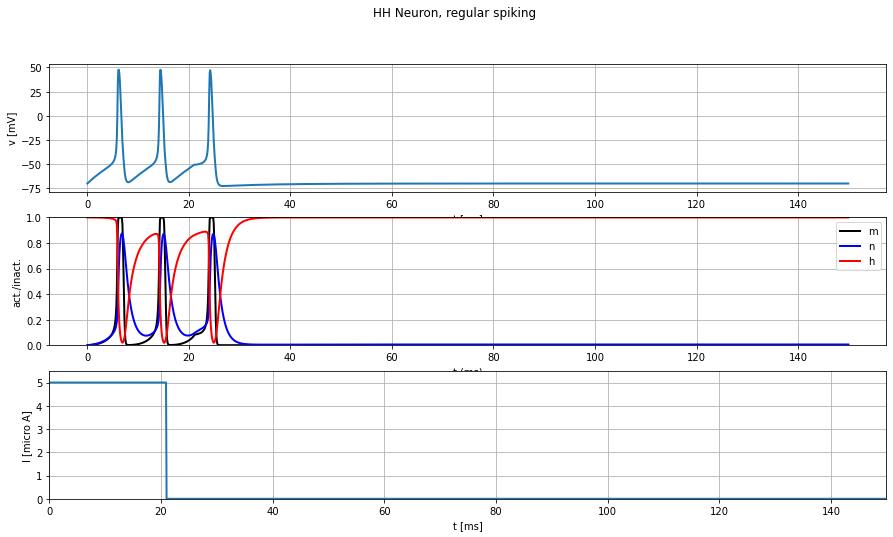

In [21]:
I_min = 5
sim_time = 150
current = input_factory.get_step_current(0, 20, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron_regular(current, sim_time * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, regular spiking")

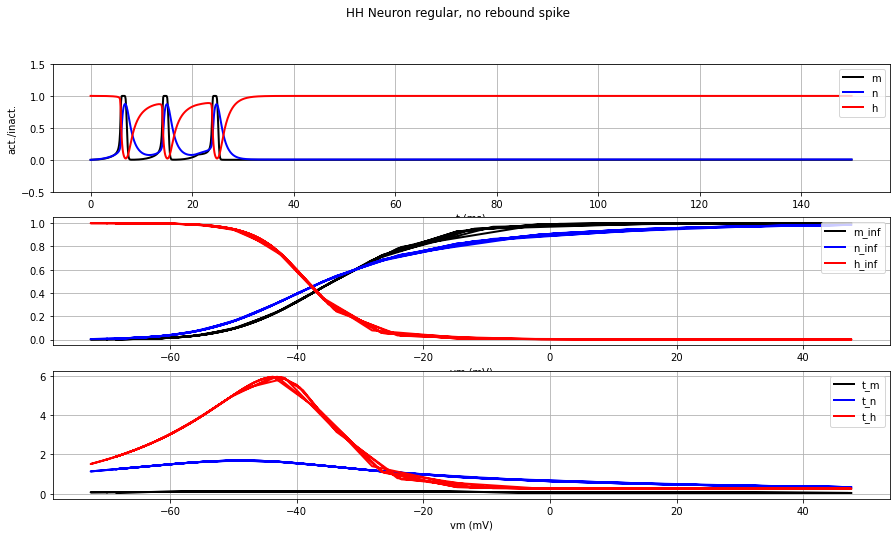

In [22]:
# Run multiple simulations with several negative currents
plot_gating_variables(state_monitor, title="HH Neuron regular, no rebound spike")

[TODO] Should be something related to the h gating variable (Potassium). From the solution of the HH notebook, it seems that injecting the negative current draws the membrane potential close to the Potassium reversal potential. But in our case, this reversal potential is much bigger in absolute value (-90 against -12 in the exercise). So it is not met and we don't have the same effect as before.

Possibility: when the potential is very negative, the objective values m_inf, n_inf, h_inf are constant. In parallel, the time constants are very close (small => FAST). Therefore all the gating variables quickly go back to the same values and nothing changes => no spike. When the input current increases and the potential overpass -50, the objective values are already quite different: h_inf decreases to 0 to inactivate and m_inf increases to activate. Since t_h is much higher than t_m, the channel opens quickly and closes slowly => the current passes => a spike is generated.

## 1.3 Adaptation

We see that as the simulation goes on, the spike frequency decreases (spikes occur less often). This is due to the variable I_M (slow non activating current). At the moment of the spike, t_p becomes very small => fast change and p decreases quickly to EK (even lower). Then, right after the spike, V is very negative so t_p is bigger => slow increase, which makes the increase of V even slower than before => the time before the next spike will be bigger.

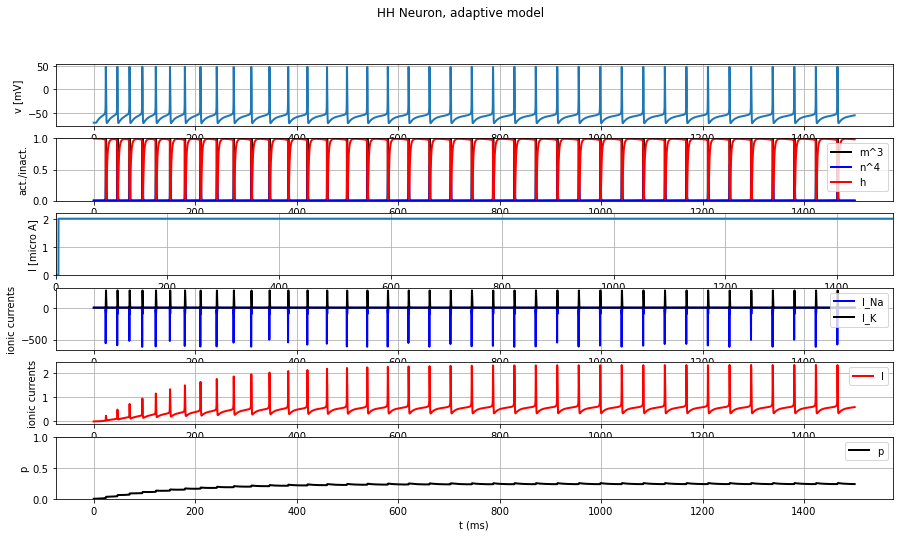

In [10]:
I_min = 2
sim_time = 1500
current = input_factory.get_step_current(5, 1500, b2.ms, I_min *b2.uA)
state_monitor_adaptive = simulate_HH_neuron_adaptive(current, sim_time * b2.ms)
plot_data(state_monitor_adaptive, title="HH Neuron, adaptive model", model_type='adaptive')

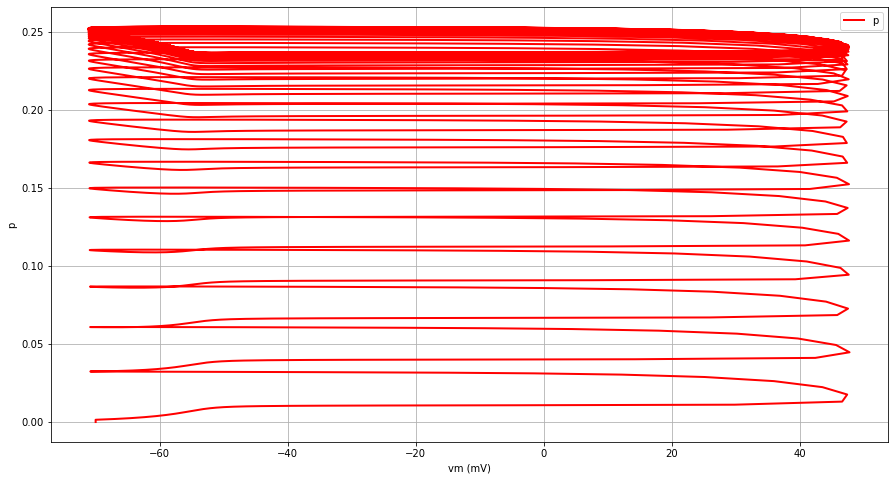

In [11]:
# Plot t_p as a function of vm
plt.plot(state_monitor_adaptive.vm[0] / b2.mV, state_monitor_adaptive.p[0] / b2.volt, "red", lw=2)
plt.xlabel("vm (mV)")
plt.ylabel("p")
plt.legend(("p"), loc='upper right')
plt.grid()

WARNING    /tmp/ipykernel_49386/2424631004.py:30: UserWarning: Attempting to set identical bottom == top == 2.2 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


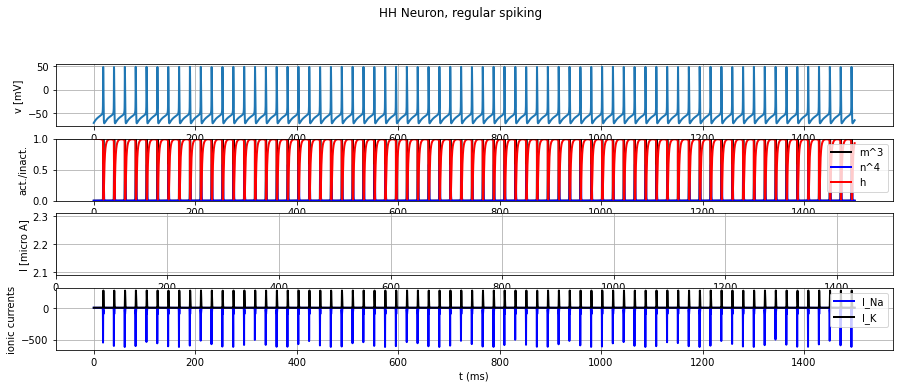

In [12]:
I_min = 2
sim_time = 1500
current = input_factory.get_step_current(0, 1500, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron_regular(current, sim_time * b2.ms)
plot_data(state_monitor, title="HH Neuron, regular spiking")